In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
try:
    import rlmep

    print("Already installed")
except ImportError:
    %pip install "rlmep[colab] @ git+https://github.com/Mads-PeterVC/rlmep.git" # if you are using Google Colab

Already installed


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from ase.calculators.emt import EMT
from ase.visualize import view

from rlmep.data import get_cluster_data
from rlmep.exercise_1 import DQN, ExperienceReplay
from rlmep.exercise_2 import GridSpec, plot_qvalues
from rlmep.exercise_2.discrete_mep_scaffold import (
    ScaffoldDiscreteMEP,
    _get_cheat_functions,
)


### (Slightly) More interesting example.

In [ ]:
initial_config, final_config = get_cluster_data(level=0)

In [5]:
view(initial_config, viewer="x3d", show_unit_cell=True)

In [6]:
view(final_config, viewer="x3d", show_unit_cell=True)

We need to setup the environment which involves a few steps; 

Setting up the grid: 
- Choose the `grid_size`
- Choose a `grid_spacing`
- Choose the lower-left `corner` of the grid in (x, y)-coordinates.
- Choose the z-coordinate of the moving atom.

Hyperparameters; 
- `barrier_max`: The barrier that corresponds to a reward of 0 ($\Delta_{max}$ in the reward function).
- `reward_scale`: Corresponds to `A` in the reward function.

Others; 
- `moving_atom`: is the index of the atom being moved - in this case the last atom.

In [9]:
functions = _get_cheat_functions()

initial_config, final_config = get_cluster_data(level=0)

grid_spec = GridSpec(
    grid_size=(15, 8),
    grid_spacing=0.5,
    corner=(10, 14),
    height=initial_config.positions[0][2],
)

env = ScaffoldDiscreteMEP(
    initial_config=initial_config,
    final_config=final_config,
    gridspec=grid_spec,
    functions=functions,
    moving_atom=-1,
    max_steps=100,
    barrier_max=5.0,
    reward_scale=10.0,
    calculator=EMT(),
)

Text(0.5, 1.0, 'Return: 7.13 \n Barrier: 1.43')

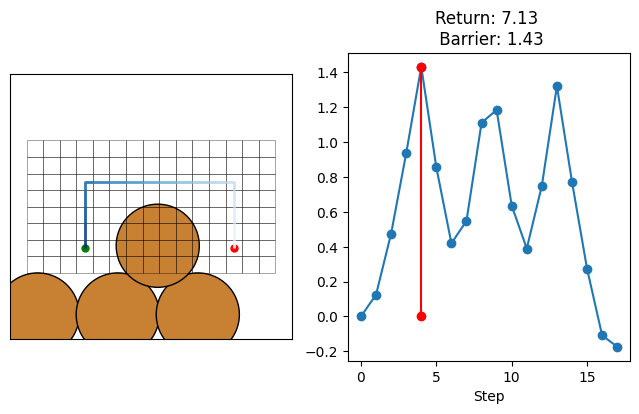

In [ ]:
# Perform a rollout to visualize a path in the environment
state, _ = env.reset()

y_steps = 4
action_sequence = [2] * y_steps + [1] * 9 + [3] * y_steps
state_history = [state]
return_value = 0
for action in action_sequence:
    state, reward, terminal, truncated, info = env.step(action)
    state_history.append(state)
    return_value += reward
    if terminal or truncated:
        break

fig, ax = plt.subplots(1, 2, figsize=(2 * 4, 4))

env.reset()
env.visualize(ax=ax[0], dx=0.5, dy=2, plot_moving=False, state_history=state_history)

delta_path = info["history"]
max_barrier = np.max(delta_path)
index_max = np.argmax(delta_path)

ax[1].plot(delta_path, "-o", label="Energy")
ax[1].plot([index_max, index_max], [0, max_barrier], "-ro", label=f"Max Barrier: {max}")
ax[1].set_xlabel("Step")
ax[1].set_title(f"Return: {return_value:0.2f} \n Barrier: {max_barrier:0.2f}")


In [18]:
env.reset()

# Set the action and observation dimensions:
obs_dim = 2
n_actions = 4

# Set the network settings:
main_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
target_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
replay = ExperienceReplay(observation_dim=obs_dim, size=2000, batch_size=32)

# Make a learner:
learner = DQN(
    main_network,
    target_network,
    replay,
    gamma=0.90,
    train_interval=1,
    copy_interval=25,
    # epsilon=lambda i: 1 - (i / num_episodes) * 0.9,
    epsilon=lambda i: 0.1,
)
num_episodes = 1000
returns, lengths = learner.learn(
    env=env,
    num_episodes=num_episodes,
)

test_returns, test_lengths = learner.test(env=env, num_episodes=10)

Output()

Output()

In [22]:
Q_table_nn = np.zeros((env.gridspec.grid_size[0], env.gridspec.grid_size[1], 4))
for i in range(env.gridspec.grid_size[0]):
    for j in range(env.gridspec.grid_size[1]):
        Q_table_nn[i, j, :] = (
            main_network(torch.tensor([i, j], dtype=torch.float))
            .detach()
            .numpy()
            .flatten()
        )

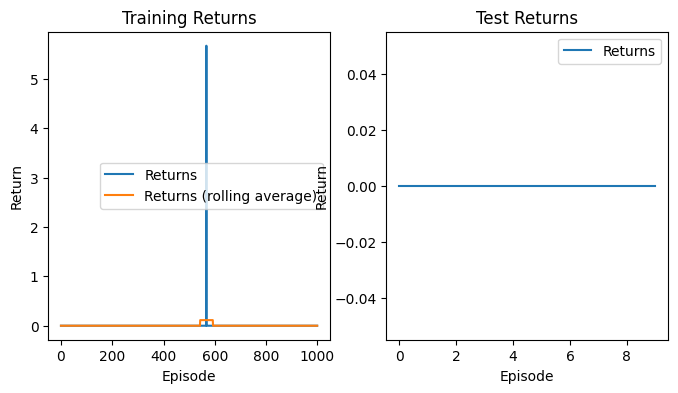

In [23]:
def rolling_average(x, N):
    return np.convolve(np.array(x).flatten(), np.ones((N,)) / N, mode="same")


fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(returns, label="Returns")
ax[0].plot(rolling_average(returns, 50), label="Returns (rolling average)")
ax[0].set_title("Training Returns")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Return")
ax[0].legend()

ax[1].plot(test_returns, label="Returns")
ax[1].set_title("Test Returns")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Return")
ax[1].legend()

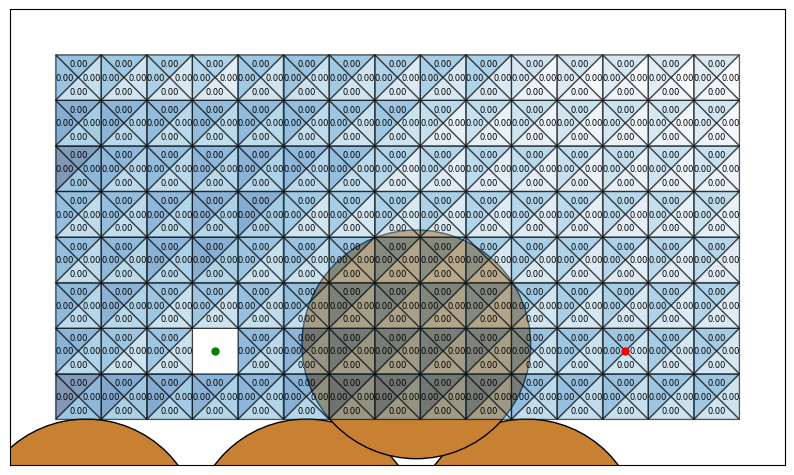

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

env.reset()
env.visualize(ax=ax, dx=0.5, dy=0.5, plot_moving=False)
ax = plot_qvalues(ax, Q_table_nn, env, alpha=0.5)